In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import astropy.io.ascii as at
import astropy.io.fits as fits
from astropy.table import Table, hstack, join
from astropy.time import Time
from astropy.coordinates import SkyCoord, Distance
import astropy.units as u
import matplotlib.ticker
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.font_manager import FontProperties
import palettable

from hypra.utils import cat_match, cat_io

# Just crossmatching against Gaia

In [2]:
gaia = at.read("gaia_vizier_allhyads_full.csv",delimiter="|",
              data_start=3)
# print(gaia.dtype)
gpos = SkyCoord(gaia["RAJ2000"],gaia["DEJ2000"],unit=u.degree)

In [3]:
hdat,_,_,_ = cat_io.get_data("H")
hpos = SkyCoord(hdat["RA"],hdat["DEC"],unit=u.degree)

In [4]:
# Match EPIC IDs
epic_list = at.read("mast_search_13064.csv",data_start=2)
print(epic_list.dtype)
mpos = SkyCoord(epic_list["RA (J2000)"], epic_list["Dec (J2000)"],
               unit=(u.hourangle,u.degree))
idx, sep, _ = hpos.match_to_catalog_sky(mpos)
print(len(idx),len(hpos),len(mpos))

good_match = np.where(sep<(5*u.arcsec))[0]
good_idx = idx[good_match]
print(len(good_match),len(good_idx),len(np.unique(good_idx)))

hdat["EPIC_ID"][good_match] = epic_list["K2 ID"][good_idx]

[('K2 ID', '<i8'), ('Dataset Name', '<U17'), ('Campaign', '<i8'), ('Object type', '<U14'), ('RA (J2000)', '<U12'), ('Dec (J2000)', '<U12'), ('Target Type', '<U2'), ('Ref', '<i8'), ('Actual Start Time', '<U19'), ('Actual End Time', '<U19'), ('Investigation ID', '<U103'), ('R Mag', '<f8'), ('R Mag Err', '<f8'), ('J Mag', '<f8'), ('J Mag Err', '<f8'), ('KEP Mag', '<f8'), ('Kep Flag', '<U3'), ('Hip ID', '<i8'), ('Tyc ID', '<U11'), ('SDSS ID', '<U20'), ('UCAC ID', '<U10'), ('2MASS ID', '<U16'), ('2MASS Flag', '<U19'), ('Module', '<i8'), ('Output', '<i8'), ('Channel', '<i8'), ('High-Level Science Products', '<i8')]
786 786 132
132 132 132


In [5]:
hdat = Table(hdat)
hdat["HYADES_IDX"] = np.arange(len(hdat))

In [6]:
idx, sep, _ = hpos.match_to_catalog_sky(gpos)
print(len(idx),len(sep),len(hpos),len(gpos))

786 786 786 999


In [7]:
good_match = np.where(sep<(5*u.arcsec))[0]
good_idx = idx[good_match]

print(len(good_idx),len(np.unique(good_idx)))
print(max(good_idx))

784 784
996


In [8]:
gaia["HYADES_IDX"] = np.ones(len(gaia),int)*-99
gaia["HYADES_IDX"][good_idx] = good_match

In [9]:
gaia = gaia[gaia["HYADES_IDX"]>=0]

In [10]:
gaia["HYADES_IDX"]

0
1
2
3
4
5
6
7
8
9
10


# Join Hyades and Gaia tables

In [11]:
joint_tab = join(hdat,gaia,join_type="left",keys=["HYADES_IDX"],
                 table_names=["Douglas","GaiaDR2"])

In [12]:
# joint_tab.dtype.names

In [13]:
# Gaia filtering (from the DR2 HRD paper):
#    RPlx > 10
#    RFG>50
#    RFBP>20
#    RFRP>20
#    E(BR/RP) < 1.3+0.06*(BP-RP)**2
#    E(BR/RP) > 1.0+0.015*(BP-RP)**2 # phot_bp_rp_excess_factor
#    Nper>8 # (visibility periods)
#    chi2AL/(NgAL-5)<1.44*greatest(1,exp(-0.4*(Gmag-19.5)))

#    astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))

# - astrometric_excess_noise<1 criterion, 
#   but this is less optimised for the bright stars 
#   because of the degrees of freedom (DOF) issue (Lindegren et al. 2018, Appendix A).
# photometric cuts may remove variable stars!

In [14]:
phot_excess = ((joint_tab["E(BR/RP)"] < (1.3+0.06*joint_tab["BP-RP"]**2)) &
               (joint_tab["E(BR/RP)"] > (1.0+0.015*joint_tab["BP-RP"]**2)))

gexp = np.exp(-0.4*(joint_tab["Gmag"]-19.5))
gexp[gexp<1] = 1
astrom = (joint_tab["chi2AL"]/(joint_tab["NgAL"]-5)) < (1.44*gexp)

hrd_filter = ((joint_tab["RPlx"]>10) & (joint_tab["RFG"]>50)
             & (joint_tab["RFBP"]>20) & (joint_tab["RFRP"]>20) 
             & phot_excess & (joint_tab["Nper"]>8)
             & astrom)

In [20]:
joint_tab["GAIA_QUAL"] = hrd_filter

## Also compare to the Gaia HRD cluster list

In [21]:
gaia_hrd = Table(at.read("gaia_HRD_Hyades.tsv",delimiter="|",data_start=3))
gaia_hrd.dtype

print(len(gaia_hrd))
print(len(np.intersect1d(np.asarray(joint_tab["Source"]),
                         np.asarray(gaia_hrd["Source"]))))

joint_tab["HRD"] = np.zeros(len(hdat),bool)

for sid in gaia_hrd["Source"]:
    loc = np.where(joint_tab["Source"]==sid)[0]
    if len(loc)==1:
        joint_tab["HRD"][loc] = True
    else:
        continue

515
409


# Comparing earlier values with Gaia

/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/core/numeric.py:492: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


Text(0,0.5,'HIP Parallax')

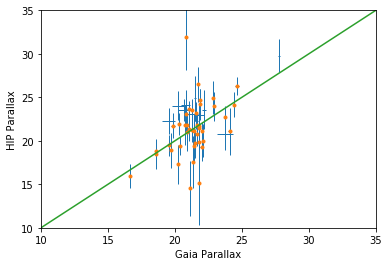

In [22]:
good_hip = joint_tab["HIP_PARALLAX"]>-999
plt.errorbar(joint_tab["Plx"][good_hip],joint_tab["HIP_PARALLAX"][good_hip],
            yerr=joint_tab["HIP_PAR_ERR"][good_hip],xerr=joint_tab["e_Plx"][good_hip],
            linewidth=0,elinewidth=1)
good_gaia = good_hip & joint_tab["GAIA_QUAL"]
plt.plot(joint_tab["Plx"][good_gaia],joint_tab["HIP_PARALLAX"][good_gaia],'.')

x = np.linspace(0,35)
plt.plot(x,x)
plt.xlim(10,35)
plt.ylim(10,35)

plt.xlabel("Gaia Parallax")
plt.ylabel("HIP Parallax")

/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/core/numeric.py:492: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


Text(0,0.5,'Goldman Parallax')

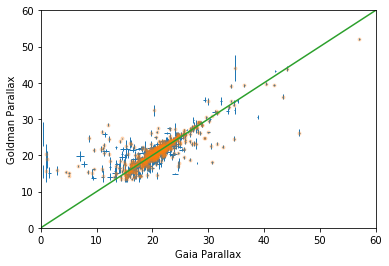

In [23]:
good_g = joint_tab["GOLDMAN_PLX"]>-999
plt.errorbar(joint_tab["Plx"][good_g],
             joint_tab["GOLDMAN_PLX"][good_g],
            yerr=joint_tab["GOLDMAN_E_PLX"][good_g],
             xerr=joint_tab["e_Plx"][good_g],
            linewidth=0,elinewidth=1)
good_gaia = good_g & joint_tab["GAIA_QUAL"]
plt.plot(joint_tab["Plx"][good_gaia],
         joint_tab["GOLDMAN_PLX"][good_gaia],'.',alpha=0.25)

x = np.linspace(0,60)
plt.plot(x,x)
plt.xlim(0,60)
plt.ylim(0,60)

plt.xlabel("Gaia Parallax")
plt.ylabel("Goldman Parallax")

# Check cross-matching with photometry

## Tycho photometry (from 2MASS), take 1

In [25]:
g_calc = np.ones(len(hdat))*np.nan

In [26]:
tycho_b = joint_tab["TWOMASS_B"]
tycho_v = joint_tab["TWOMASS_VR"]
tycho_v[joint_tab["TWOMASS_PHOT_FLAG"]!="T"] = np.nan
tycho_b[joint_tab["TWOMASS_PHOT_FLAG"]!="T"] = np.nan

In [27]:
tgood = np.isfinite(tycho_b) & (joint_tab["TWOMASS_PHOT_FLAG"]=="T")

In [28]:
bv = tycho_b - tycho_v
# https://gea.esac.esa.int/archive/documentation/GDR2/Data_processing/chap_cu5pho/sec_cu5pho_calibr/ssec_cu5pho_PhotTransf.html#Ch5.T7
g_m_v = -0.02051 - 0.2706*bv + 0.03394*bv**2 -0.05937*bv**3
g_calc[tgood] = tycho_v[tgood] + g_m_v[tgood]
g_tycho = np.copy(g_calc)

Text(0,0.5,'Calculated G')

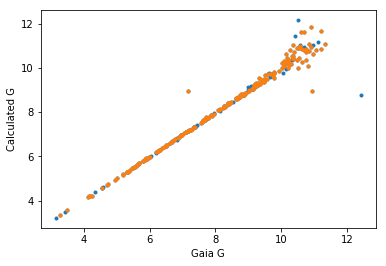

In [30]:
plt.plot(joint_tab["Gmag"],g_calc,'.')
plt.plot(joint_tab["Gmag"][joint_tab["GAIA_QUAL"]],
         g_calc[joint_tab["GAIA_QUAL"]],
        '.')

plt.xlabel("Gaia G")
plt.ylabel("Calculated G")

## UCAC r, i photometry

In [31]:
g_calc = np.ones(len(joint_tab))*np.nan

ucac_r = joint_tab["UCAC_R"]
ucac_i = joint_tab["UCAC_I"]
ugood = (ucac_r>0) & (ucac_i>0)

In [32]:
ri = ucac_r - ucac_i
# https://gea.esac.esa.int/archive/documentation/GDR2/Data_processing/chap_cu5pho/sec_cu5pho_calibr/ssec_cu5pho_PhotTransf.html#Ch5.T7
g_m_r = 0.0014891 + 0.36291*ri -0.81282*ri**2 + 0.0060376*ri**3
g_calc[ugood] = ucac_r[ugood] + g_m_r[ugood]
g_ucac = np.copy(g_calc)

Text(0,0.5,'Calculated G')

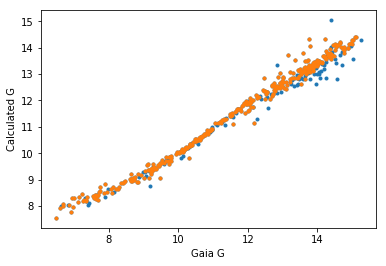

In [33]:
plt.plot(joint_tab["Gmag"],g_calc,'.')
plt.plot(joint_tab["Gmag"][joint_tab["GAIA_QUAL"]],
         g_calc[joint_tab["GAIA_QUAL"]],
        '.')
plt.xlabel("Gaia G")
plt.ylabel("Calculated G")

In [34]:
len(np.where(np.isnan(g_calc))[0])

337

## SDSS r,i photometry

In [35]:
g_calc = np.ones(len(joint_tab))*np.nan

sdss_r = joint_tab["SDSS_R"]
sdss_i = joint_tab["SDSS_I"]
sgood = (sdss_r>14) & (sdss_i>14)

In [36]:
ri = sdss_r - sdss_i
# https://gea.esac.esa.int/archive/documentation/GDR2/Data_processing/chap_cu5pho/sec_cu5pho_calibr/ssec_cu5pho_PhotTransf.html#Ch5.T7
g_m_r = 0.0014891 + 0.36291*ri -0.81282*ri**2 + 0.0060376*ri**3
g_calc[sgood] = sdss_r[sgood] + g_m_r[sgood]
g_sdss = g_calc

Text(0,0.5,'Calculated G')

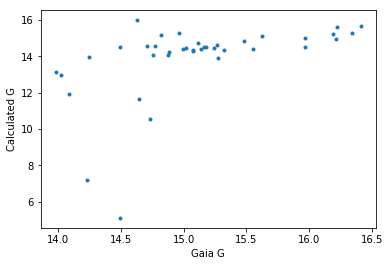

In [37]:
plt.plot(joint_tab["Gmag"],g_calc,'.')
plt.xlabel("Gaia G")
plt.ylabel("Calculated G")

In [39]:
len(np.where(np.isnan(g_calc))[0])

747

(0, 25)

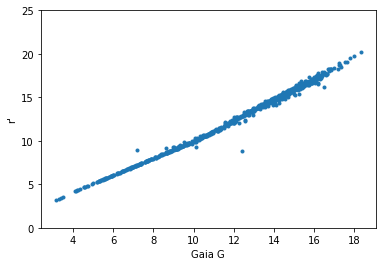

In [38]:
plt.plot(joint_tab["Gmag"],joint_tab["RPRIME"],'.')
plt.xlabel("Gaia G")
plt.ylabel("r'")
plt.ylim(0,25)

## 2MASS

In [42]:
jmk = joint_tab["TWOMASS_J"] - joint_tab["TWOMASS_K"]
need_jmk = joint_tab["TWOMASS_J"]<=0
jmk[need_jmk] = joint_tab["GOLDMAN_JMAG"][need_jmk] - joint_tab["GOLDMAN_KMAG"][need_jmk]
hmk = joint_tab["TWOMASS_H"] - joint_tab["TWOMASS_K"]
hmk[need_jmk] = joint_tab["GOLDMAN_HMAG"][need_jmk] - joint_tab["GOLDMAN_KMAG"][need_jmk]

In [43]:
print(max(jmk),max(hmk))

1.446 0.582


In [45]:
calc_bprp = 0.20215 + 1.9561*jmk -0.69629*jmk**2 + 0.47633*jmk**3

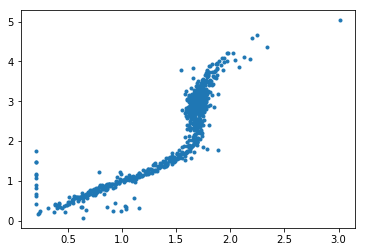

In [47]:
plt.plot(calc_bprp,joint_tab["BP-RP"],'.')

In [48]:
calc_GmK = 0.23587 + 4.0548*jmk - 2.5608*jmk**2 + 2.2228*jmk**3 -0.54944*jmk**4

In [49]:
kmag = hdat["TWOMASS_K"]
kmag[kmag<=0] = hdat["GOLDMAN_KMAG"][kmag<=0]

In [50]:
calc_G = calc_GmK + kmag

(0, 20)

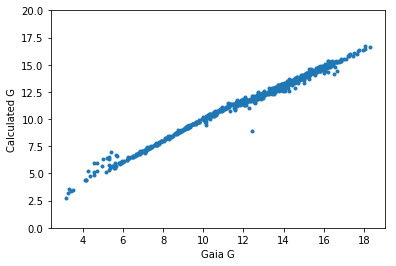

In [51]:
plt.plot(joint_tab["Gmag"],calc_G,'.')
plt.xlabel("Gaia G")
plt.ylabel("Calculated G")
plt.ylim(0,20)

In [53]:
ucac_diff = abs(joint_tab["Gmag"] - g_ucac)
sdss_diff = abs(joint_tab["Gmag"] - g_sdss)
tycho_diff = abs(joint_tab["Gmag"] - g_tycho)
gK_diff = abs(joint_tab["Gmag"]-calc_G)

In [54]:
print(np.median(ucac_diff[np.isfinite(ucac_diff)]),np.median(sdss_diff[np.isfinite(sdss_diff)]))
print(np.median(tycho_diff[np.isfinite(tycho_diff)]),np.median(gK_diff[gK_diff<10000]))
print(np.std(ucac_diff[np.isfinite(ucac_diff)]),np.std(sdss_diff[np.isfinite(sdss_diff)]))
print(np.std(tycho_diff[np.isfinite(tycho_diff)]),np.std(gK_diff[gK_diff<10000]))

0.3811041778564448 0.7697585830688478
0.03451955337524382 0.771258944702149
0.3437830782358067 1.794329748629404
0.3280753103148325 0.5142340043357276


/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:664: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [56]:
ucac_lim = np.median(ucac_diff[np.isfinite(ucac_diff)]) + np.std(ucac_diff[np.isfinite(ucac_diff)])#*2
sdss_lim = np.median(sdss_diff[np.isfinite(ucac_diff)]) + np.std(sdss_diff[np.isfinite(sdss_diff)])#*2
tycho_lim = np.median(tycho_diff[np.isfinite(ucac_diff)]) + np.std(tycho_diff[np.isfinite(tycho_diff)])#*2
tmass_lim = np.median(gK_diff[gK_diff<10000]) + np.std(gK_diff[gK_diff<10000])*2

print(len(np.where(ucac_diff>ucac_lim)[0]))
print(len(np.where(sdss_diff>sdss_lim)[0]))
print(len(np.where(tycho_diff>tycho_lim)[0]))
print(len(np.where(gK_diff>tmass_lim)[0]))
# print(np.where(((ucac_diff>0.86) & np.isfinite(ucac_diff))
#                & ((sdss_diff>1.46) & np.isfinite(sdss_diff))
#                & ((tycho_diff>0.06)  & np.isfinite(tycho_diff))
#                & ((gK_diff>1.6) & (gK_diff<10000)))[0])
bad_match = np.where(((ucac_diff>ucac_lim) | np.isnan(ucac_diff))
               & ((sdss_diff>sdss_lim) | np.isnan(sdss_diff))
               & ((tycho_diff>tycho_lim)  | np.isnan(tycho_diff))
               & ((gK_diff>tmass_lim) | (gK_diff>10000)))[0]

no_match = np.where(np.isnan(ucac_diff) & np.isnan(sdss_diff)
                    & np.isnan(tycho_diff) & (gK_diff>10000))[0]
print(no_match)
print(joint_tab["Gmag"][no_match])

print(bad_match)
for i in bad_match:
    if i in no_match:
#         continue
        print("\nNo phot",joint_tab["RMAG"][i],joint_tab["RMAG_FLAG"][i])
        print("UCAC",joint_tab["UCAC_R"][i],joint_tab["UCAC_I"][i])
        print(i,joint_tab["GOLDMAN_SEQ"][i],joint_tab["HIP_ID"][i])
    else:
        print("\nUCAC",ucac_diff[i],"SDSS",sdss_diff[i])
        print("Tycho2",tycho_diff[i],"2MASS",gK_diff[i])
#         print(i,joint_tab["GOLDMAN_SEQ"][i],joint_tab["GOLDMAN_RMAG"][i])
        print("G=",joint_tab["Gmag"][i],joint_tab["GAIA_QUAL"][i],joint_tab["Source"][i])
        print("Prot=",joint_tab["PERIOD"][i],"EPIC",joint_tab["EPIC_ID"][i])

83
0
0
17
[ 9 46 89]
 Gmag 
------
 3.998
6.2899
7.6685
[  9  46  72  89  91 349 443 562]

No phot -9999.0 C
UCAC -9999.0 -9999.0
9 -9999 HIP14838

No phot -9999.0 C
UCAC -9999.0 -9999.0
46 -9999 HIP14232

UCAC 1.1926854217529295 SDSS nan
Tycho2 nan 2MASS 10005.914871875
G= 7.1512 True 64115585330656000
Prot= -99.0 EPIC -9999

No phot -9999.0 C
UCAC -9999.0 7.93
89 -9999 HIP20218

UCAC 0.9727545455932614 SDSS nan
Tycho2 nan 2MASS 10006.498271875
G= 7.7346 True 149726790484381568
Prot= -99.0 EPIC -9999

UCAC nan SDSS nan
Tycho2 nan 2MASS 2.3519606292724617
G= 16.5088 -- 3312212503036012416
Prot= -99.0 EPIC -9999

UCAC nan SDSS nan
Tycho2 nan 2MASS 2.207284149169922
G= 16.634 True 3313665885609887616
Prot= -99.0 EPIC -9999

UCAC nan SDSS nan
Tycho2 nan 2MASS 1.8483402557373054
G= 16.207 False 3406246551373367168
Prot= -99.0 EPIC 246953721


/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:664: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


In [60]:
# but it appears some stars lack Gaia matches?
print(np.where(joint_tab["Gmag"].mask==True)[0])
no_match = np.where(joint_tab["Gmag"].mask==True)[0]
print(joint_tab["RA"][no_match],joint_tab["DEC"][no_match])
print(joint_tab["PERIOD"][no_match],joint_tab["EPIC_ID"][no_match])

[654 672]
    RA    
----------
77.4394697
79.1257739    DEC    
----------
28.0336228
-9.8306886
PERIOD
------
 -99.0
 -99.0 EPIC_ID
-------
  -9999
  -9999


So every rotator and possible K2 target has a Gaia match that looks reasonable. 3 stars are missing the photometry to confirm their matches, 5 do fail the photometry cross-check, and 2 stars do not have Gaia crossmatches, but none of those 10 stars will be included in the paper anyway.

In [62]:
joint_tab.dtype.names

('RA',
 'DEC',
 'ASAS_ID',
 'HIP_ID',
 'KUNDERT_MATCH',
 'KUNDERT_RA',
 'KUNDERT_DEC',
 'KUNDERT_PROT',
 'KUNDERT_OBS',
 'KUNDERT_SPT',
 'ROESER_MATCH',
 'ROESER_PMRA',
 'ROESER_PMRA_ERR',
 'ROESER_PMDEC',
 'ROESER_PMDEC_ERR',
 'ROESER_PARALLAX',
 'ROESER_PARALLAX_ERR',
 'ROESER_DISTANCE',
 'ROESER_RV',
 'ROESER_VPAR',
 'ROESER_VPAR_ERR',
 'ROESER_VPER',
 'ROESER_VPER_ERR',
 'ROESER_MASS',
 'TWOMASSNAME',
 'TWOMASS_RA',
 'TWOMASS_DEC',
 'TWOMASS_J',
 'TWOMASS_JERR',
 'TWOMASS_H',
 'TWOMASS_HERR',
 'TWOMASS_K',
 'TWOMASS_KERR',
 'TWOMASS_FLAG',
 'TWOMASS_PHOT_FLAG',
 'TWOMASS_SEP_OPT',
 'TWOMASS_B',
 'TWOMASS_VR',
 'DELORME_MATCH',
 'SWASP_ID',
 'USNO_ID',
 'DELORME_RA',
 'DELORME_DEC',
 'DELORME_XRAY',
 'DELORME_V',
 'DELORME_PREV_SPT',
 'DELORME_PMEM',
 'DELORME_LITP',
 'DELORME_DELTACORE',
 'DELORME_PARALLAX',
 'DELORME_DISTANCE',
 'ANYPERIOD',
 'UCAC_MATCH',
 'UCAC_RA',
 'UCAC_DEC',
 'UCAC_ID',
 'UCAC_FLAG',
 'UCAC_DBLSTAR',
 'UCAC_PMRA',
 'UCAC_PMDEC',
 'UCAC_J',
 'UCAC_JERR',
 'UC

In [68]:
out_names = ["HYADES_IDX","RA","DEC","HIP_ID","ROESER_MATCH","TWOMASSNAME",
            "TWOMASS_J","TWOMASS_JERR","TWOMASS_H","TWOMASS_HERR",
             "TWOMASS_K","TWOMASS_KERR","TWOMASS_PHOT_FLAG","TWOMASS_B",
            "TWOMASS_VR","SWASP_ID","USNO_ID","DELORME_LITP","UCAC_MATCH",
            "UCAC_ID",
             "UCAC_R", "UCAC_RERR","UCAC_I","UCAC_IERR","SDSS_MATCH",
            "SDSS_R","SDSS_RERR","SDSS_I","SDSS_IERR","HIP_PARALLAX",
            "HIP_PAR_ERR","RPRIME","RMAG_FLAG","GOLDMAN_MATCH","GOLDMAN_SEQ",
            "GOLDMAN_PLX","GOLDMAN_E_PLX","GOLDMAN_RMED","GOLDMAN_E_RMED",
            "GOLDMAN_IMED","GOLDMAN_E_IMED","PROSSER_PERIOD","HARTMAN_PERIOD",
            "EPIC_ID","K2_PERIOD","DR2Name","RA_ICRS","e_RA_ICRS","DE_ICRS",
            "e_DE_ICRS","Source","Epoch","Plx","e_Plx","pmRA","e_pmRA",
            "pmDE","e_pmDE","Gmag","e_Gmag","BPmag","e_BPmag","RPmag",
             "e_RPmag","E(BR/RP)","BP-RP","RV","e_RV",
             "RPlx","RFG","NgAL","chi2AL","RFBP","RFRP","Nper",
            "HRD","GAIA_QUAL"]

In [69]:
out_tab = joint_tab[out_names]

In [70]:
out_tab.show_in_notebook()

idx,HYADES_IDX,RA,DEC,HIP_ID,ROESER_MATCH,TWOMASSNAME,TWOMASS_J,TWOMASS_JERR,TWOMASS_H,TWOMASS_HERR,TWOMASS_K,TWOMASS_KERR,TWOMASS_PHOT_FLAG,TWOMASS_B,TWOMASS_VR,SWASP_ID,USNO_ID,DELORME_LITP,UCAC_MATCH,UCAC_ID,UCAC_R,UCAC_RERR,UCAC_I,UCAC_IERR,SDSS_MATCH,SDSS_R,SDSS_RERR,SDSS_I,SDSS_IERR,HIP_PARALLAX,HIP_PAR_ERR,RPRIME,RMAG_FLAG,GOLDMAN_MATCH,GOLDMAN_SEQ,GOLDMAN_PLX,GOLDMAN_E_PLX,GOLDMAN_RMED,GOLDMAN_E_RMED,GOLDMAN_IMED,GOLDMAN_E_IMED,PROSSER_PERIOD,HARTMAN_PERIOD,EPIC_ID,K2_PERIOD,DR2Name,RA_ICRS,e_RA_ICRS,DE_ICRS,e_DE_ICRS,Source,Epoch,Plx,e_Plx,pmRA,e_pmRA,pmDE,e_pmDE,Gmag,e_Gmag,BPmag,e_BPmag,RPmag,e_RPmag,E(BR/RP),BP-RP,RV,e_RV,RPlx,RFG,NgAL,chi2AL,RFBP,RFRP,Nper,HRD,GAIA_QUAL
0,0,67.16531227,15.87094681,HIP20894,1,X,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-,nan,nan,no string,no string,-9999.0,1,530-008822,-9999.0,-0.09,-9999.0,-0.09,0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,C,1,359,22.37,0.12,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999,0.0,Gaia DR2 3312744219987686144,67.16606480353,0.3224,15.87078720043,0.2329,3312744219987686144,2015.5,20.8354,0.3731,103.33,0.748,-18.625,0.574,3.3066,0.0036,3.649,0.0261,3.202,0.002,1.004,0.447,--,--,55.8457,302.562,349,135245.88,41.618,535.773,12,True,True
1,1,67.15388847,19.18052103,HIP20889,1,04283697+1910494,1.748,0.284,1.314,0.226,1.422,0.254,T,4.53,3.53,no string,no string,-9999.0,1,546-009607,-9999.0,-0.09,-9999.0,-0.09,0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,3.2082903,T,1,357,22.01,0.08,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999,0.0,Gaia DR2 48026706557926528,67.15465729102,0.3701,19.18027817758,0.2481,48026706557926528,2015.5,20.313,0.4261,107.503,1.036,-38.066,0.7,3.1587,0.0029,3.9236,0.0151,2.6921,0.0068,1.017,1.2315,--,--,47.6753,370.084,229,56717.47,71.768,160.036,9,False,False
2,2,64.94805797,15.6277001,HIP20205,1,04194757+1537395,1.963,0.246,1.496,0.21,1.518,0.204,T,4.61,3.65,no string,no string,-9999.0,1,529-008241,-9999.0,-0.09,-9999.0,-0.09,0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,3.341562,T,1,229,22.33,0.08,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999,0.0,Gaia DR2 3312052249216467328,64.94886907388,0.3818,15.62754121767,0.3168,3312052249216467328,2015.5,22.6234,0.4614,113.158,0.967,-25.27,0.759,3.29,0.0009,4.0299,0.026,2.8078,0.0061,1.035,1.2221,--,--,49.0321,1247.398,189,51094.42,41.741,179.386,10,True,True
3,3,65.73344726,17.54258445,HIP20455,1,04225609+1732331,2.094,0.248,1.579,0.198,1.643,0.228,T,4.72,3.76,no string,no string,-9999.0,1,538-008812,-9999.0,-0.09,-9999.0,-0.09,0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,3.4510612,T,1,261,21.1,0.15,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999,0.0,Gaia DR2 3314024566918614528,65.73420939642,0.3811,17.54239464643,0.2135,3314024566918614528,2015.5,19.0632,0.3699,100.78,0.92,-28.08,0.64,3.4155,0.0019,4.0635,0.0071,2.9031,0.0019,1.087,1.1604,--,--,51.5351,582.518,385,76033.01,153.632,572.239,8,True,False
4,4,67.14346811,15.9622172,HIP20885,1,04283447+1557437,2.142,0.23,1.754,0.19,1.644,0.218,T,4.77,3.84,no string,no string,-9999.0,1,530-008817,-9999.0,-0.09,-9999.0,-0.09,0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,3.543243,T,1,356,21.12,0.06,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999,0.0,Gaia DR2 3312748824191278208,67.14421556282,0.3537,15.96203326256,0.2633,3312748824191278208,2015.5,21.4183,0.3457,111.325,0.933,-62.161,0.761,3.4931,0.004,4.1515,0.0059,3.0064,0.0024,1.067,1.1451,--,--,61.9497,270.929,311,75983.42,182.927,444.521,10,False,True
5,5,66.3420783,22.29398101,HIP20635,1,04252215+2217381,4.093,0.284,4.064,0.228,4.077,0.47,T,4.34,4.2,no string,no string,-9999.0,1,562-010189,-9999.0,-0.09,-9999.0,-0.09,0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,4.250904,T,1,309,21.27,0.05,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999,0.0,Gaia DR2 145674574739951872,66.34283716887,0.2966,22.29367965313,0.2147,145674574739951872,2015.5,21.4871,0.3644,101.028,0.943,-44.473,0.737,4.1131,0.0031,4.2604,0.0018,4.0612,0

In [ ]:
nulls = ["nan","-","-9999.0","no_string","-9999","0.0" # for K2_PERIOD - uhoh
         "HIP0","X"]